In [1]:
#Importing all the Libraries required to run this project
import pandas as pd
import requests
import tweepy
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering Data



1. Twitter Archive File - The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

2. Image Prediction File - The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

3. Tweet JSON File - Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.


In [2]:
# Importing Image Prediction file to Jupyter Notebook using below code
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split('/')[-1],mode='wb') as img_pred_file:
    img_pred_file.write(response.content) 

In [3]:
# Reading both Twitter Archive File and Image Predictions file using Pandas
twit_arc_enh = pd.read_csv('twitter-archive-enhanced.csv')
img_pred = pd.read_csv('image-predictions.tsv', sep='\t')

In [15]:
# Authorising Tweeter Developers account and creating object to fetch data through JSON
auth = tweepy.OAuthHandler(HIDDEN)
auth.set_access_token(HIDDEN)

api = tweepy.API(auth, 
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

## Running the loop to get ONLY the entire JSON data for each and every Tweeter ID's in Archive Dataframe into tweet_json.txt
tweet_found = []
tweet_not_found = []

for tweet_id in twit_arc_enh['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        tweet_found.append(tweet._json)
    except tweepy.TweepError as e:
        tweet_not_found.append(tweet_id)


Rate limit reached. Sleeping for: 738
Rate limit reached. Sleeping for: 738


In [16]:
print(len(tweet_found))
print(len(tweet_not_found))

2331
25


In [17]:
#This is to format the above json file which got extracted from Twitter API and storing it to tweet_json.txt file.

fmt_json = []
for twt_json in tweet_found:
    fmt_json.append(twt_json)
with open('tweet_json.txt', 'w') as file:
    file.write(json.dumps(fmt_json, indent=4))
        
notfound_json = pd.DataFrame(tweet_not_found)
notfound_json.to_csv('tweet_notfound_json.txt', header=None, index=None, mode='a')

In [135]:
#Prepared a new list to pick the required values form JSON file and write it to DataFrame.
retwt_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    
    for json_field in all_data:
        tweet_id = json_field['id']
        full_tweet = json_field['full_text']
        web_url = full_tweet[full_tweet.find('https'):]
        retweet_count = json_field['retweet_count']
        favorite_count = json_field['favorite_count']
        retweeted_result = json_field['retweeted_status'] = json_field.get('retweeted_status', 'Original tweet')
        if retweeted_result == 'Original tweet':
            url = web_url
        else:
            retweeted_result == 'This is a retweet'
            url = 'This is a retweet'
        
        retwt_list.append({'tweet_id':tweet_id,
                             'retweet_count':retweet_count,
                             'favorite_count':favorite_count,
                             'retweeted_result':retweeted_result,
                             'url': url
                            })
        
    retwt_DataFrame = pd.DataFrame(retwt_list, columns = ['tweet_id','retweet_count','favorite_count','retweeted_result','url'])

In [136]:
retwt_DataFrame.sample(10)

,tweet_id,retweet_count,favorite_count,retweeted_result,url
804,769335591808995329,7455,0,{'created_at': 'Mon Mar 07 18:09:06 +0000 2016...,This is a retweet
285,836989968035819520,2194,12340,Original tweet,https://t.co/beWUzGVKRM
952,750026558547456000,752,2623,Original tweet,https://t.co/jrg29NDNhI
1540,688116655151435777,735,2708,Original tweet,https://t.co/YdLytdZOqv
1315,704871453724954624,1064,4092,Original tweet,https://t.co/mIQ1KoVsmU
1219,711968124745228288,2185,7686,Original tweet,https://t.co/2e6cUtKUuc
801,770069151037685760,2210,7377,Original tweet,https://t.co/mADHGenzFS
1684,680798457301471234,977,2715,Original tweet,https://t.co/w6fRfQ3RXD
165,858843525470990336,3156,14550,Original tweet,https://t.co/cUeDMlHJbq
2156,668994913074286592,204,402,Original tweet,https://t.co/w5oYFXi0uh


# Assessing Data

## Quality Issues

Visual Assessment

1. In twit_arc_enh, Drop all 181 rows containing retweets, where these columns will be non-null: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp.
2. In twit_arc_enh, Drop all 78 rows containing replies, where those that have non-null values in these columns: in_reply_to_status_id and in_reply_to_user_id.
3. In twit_arc_enh, timestamp and retweeted_status_timestamp are of object type. It should be timestamp type.
4. In img_pred, Greatest of all probablity with TRUE value will be taken into one column
5. In img_pred, Prediction names are having _ hence remove it with space

Programmatic Assessment

1. In twit_arc_enh, numerator values as 1776, 960, 666, 420, 143
2. In twit_arc_enh, denominator values as 11, 170, 50 are moved to 10
3. In twit_arc_enh, extract the string in between the html tags for Source column
4. In retwt_DataFrame, remove 163 retweets

### ** As per review comments Dog Type columns restructoring falls into Tidiness Issues

## Tidiness Issues

1. Dog Type columns should be re-structured into one columns to show the value in one.
2. Merge all the Dataframes into one to visualise

### ** As per Review dropping the unwanted columns is neither comes in Quality or Tidiness issue
1. Unwanted columns in twit_arc_enh needs to be dropped.
2. Unwanted columns in img_pred need to be dropped after we finalise Prediction and Confidence for each dog
3. Unwanted columns in retwt_DataFrame needs to be dropped.

In [137]:
twit_arc_enh

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [138]:
img_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [139]:
retwt_DataFrame

,tweet_id,retweet_count,favorite_count,retweeted_result,url
0,892420643555336193,7319,34874,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,5466,30205,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,3607,22734,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,7508,38142,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,8061,36408,Original tweet,https://t.co/AtUZn91f7f
5,891087950875897856,2704,18375,Original tweet,https://t.co/kQ04fDDRmh
6,890971913173991426,1746,10692,Original tweet,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl
7,890729181411237888,16416,58750,Original tweet,https://t.co/v0nONBcwxq
8,890609185150312448,3754,25287,Original tweet,https://t.co/9TwLuAGH0b
9,890240255349198849,6341,28840,Original tweet,https://t.co/t1bfwz5S2A


In [140]:
twit_arc_enh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [141]:
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [142]:
retwt_DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id            2331 non-null int64
retweet_count       2331 non-null int64
favorite_count      2331 non-null int64
retweeted_result    2331 non-null object
url                 2331 non-null object
dtypes: int64(3), object(2)
memory usage: 91.1+ KB


In [143]:
twit_arc_enh.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [144]:
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [145]:
retwt_DataFrame.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2574.233805,7281.700987
std,6.823170e+16,4354.205557,11310.990220
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,522.500000,1260.000000
50%,7.182469e+17,1200.000000,3153.000000
75%,7.986692e+17,2980.500000,8898.500000
max,8.924206e+17,73854.000000,149698.000000


# twit_arc_enh

In [146]:
# Finding the Number of rows present having a value in retweeted_status_id
sum(twit_arc_enh.retweeted_status_id.notnull())

181

In [147]:
# Finding the Number of rows present having a value in in_reply_to_status_id
sum(twit_arc_enh.in_reply_to_status_id.notnull())

78

In [148]:
twit_arc_enh.source[10]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [149]:
# Checking the Numerator value in twit_arc_enh
twit_arc_enh.rating_numerator.value_counts().sort_index(ascending = False)

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

In [150]:
# Total Number of Numerator Values greater than 15
sum(twit_arc_enh.rating_numerator > 15)

26

In [151]:
# Getting the Text to analyse whether these rows needs to be cleaned or not
print((twit_arc_enh.text[twit_arc_enh.rating_numerator==1776]))
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==960])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==666])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==420])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==204])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==182])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==165])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==144])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==143])
print(twit_arc_enh.text[twit_arc_enh.rating_numerator==121])

979    This is Atticus. He's quite simply America af....
Name: text, dtype: object
313    @jonnysun @Lin_Manuel ok jomny I know you're e...
Name: text, dtype: object
189    @s8n You tried very hard to portray this good ...
Name: text, dtype: object
188     @dhmontgomery We also gave snoop dogg a 420/10...
2074    After so many requests... here you go.\n\nGood...
Name: text, dtype: object
1120    Say hello to this unbelievably well behaved sq...
Name: text, dtype: object
290    @markhoppus 182/10
Name: text, dtype: object
902    Why does this never happen at my front door......
Name: text, dtype: object
1779    IT'S PUPPERGEDDON. Total of 144/120 ...I think...
Name: text, dtype: object
1634    Two sneaky puppers were not initially seen, mo...
Name: text, dtype: object
1635    Someone help the girl is being mugged. Several...
Name: text, dtype: object


In [152]:
# Displayed complete text to check whether we can drop them or not
print(twit_arc_enh['text'][979]+ ' UL')
print(twit_arc_enh['text'][313]+ ' UL')
print(twit_arc_enh['text'][189]+ ' UL')
print(twit_arc_enh['text'][188]+ ' UL')
print(twit_arc_enh['text'][2074]+ ' UL')
print(twit_arc_enh['text'][1120]+ ' UL')
print(twit_arc_enh['text'][290]+ ' UL')
print(twit_arc_enh['text'][902]+ ' UL')
print(twit_arc_enh['text'][1779]+ ' UL')
print(twit_arc_enh['text'][1634]+ ' UL')
print(twit_arc_enh['text'][1635]+ ' UL')

This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh UL
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho UL
@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10 UL
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research UL
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY UL
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv UL
@markhoppus 182/10 UL
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE UL
IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq UL
Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3 UL
Someone help the girl is being mugged. Several are distracting her whil

In [153]:
twit_arc_enh.rating_denominator.value_counts().sort_index(ascending=False)

170       1
150       1
130       1
120       1
110       1
90        1
80        2
70        1
50        3
40        1
20        2
16        1
15        1
11        3
10     2333
7         1
2         1
0         1
Name: rating_denominator, dtype: int64

In [154]:
sum(twit_arc_enh.rating_denominator > 10)

20

In [155]:
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==70])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==150])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==11])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==170])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==20])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==50])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==90])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==40])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==110])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==120])
print(twit_arc_enh.text[twit_arc_enh.rating_denominator==80])

433    The floofs have been released I repeat the flo...
Name: text, dtype: object
902    Why does this never happen at my front door......
Name: text, dtype: object
784     RT @dog_rates: After so many requests, this is...
1068    After so many requests, this is Bretagne. She ...
1662    This is Darrel. He just robbed a 7/11 and is i...
Name: text, dtype: object
1120    Say hello to this unbelievably well behaved sq...
Name: text, dtype: object
1165    Happy 4/20 from the squad! 13/10 for all https...
1598    Yes I do realize a rating of 4/20 would've bee...
Name: text, dtype: object
1202    This is Bluebert. He just saw that both #Final...
1274    From left to right:\nCletus, Jerome, Alejandro...
1351    Here is a whole flock of puppers.  60/50 I'll ...
Name: text, dtype: object
1228    Happy Saturday here's 9 puppers on a bench. 99...
Name: text, dtype: object
1433    Happy Wednesday here's a bucket of pups. 44/40...
Name: text, dtype: object
1635    Someone help the girl is being m

In [156]:
# Getting only text based on the index value which got on above step
print(twit_arc_enh['text'][433]+ ' END') # This looks to be genuine one.
print(twit_arc_enh['text'][902]+ ' END') # There are group of dogs and hence it looks to be genuine.
print(twit_arc_enh['text'][1068]+ ' END') # Correct Denominator is 10 rather than 11
print(twit_arc_enh['text'][1662]+ ' END') # Correct Denominator is 10 rather than 11
print(twit_arc_enh['text'][1120]+ ' END') # Looks to be correct as bunch of dogs
print(twit_arc_enh['text'][1165]+ ' END') # Correct Denominator is 10 rather than 20
print(twit_arc_enh['text'][1598]+ ' END') # Correct Denominator is 10 rather than 20
print(twit_arc_enh['text'][1202]+ ' END') # There is no image url hence we can drop this one.
print(twit_arc_enh['text'][1274]+ ' END') # Correct Denominator is 10 rather than 50
print(twit_arc_enh['text'][1351]+ ' END') # Looks to be genuine as there are bunch of dogs.
print(twit_arc_enh['text'][1228]+ ' END') # Looks to be genuine as there are bunch of dogs.
print(twit_arc_enh['text'][1433]+ ' END') # Looks to be genuine as there are bunch of dogs.
print(twit_arc_enh['text'][1635]+ ' END') # Looks to be genuine as there are bunch of dogs.
print(twit_arc_enh['text'][1779]+ ' END') # Looks to be genuine as there are bunch of dogs.
print(twit_arc_enh['text'][1254]+ ' END') # Looks to be genuine as there are bunch of dogs.
print(twit_arc_enh['text'][1843]+ ' END') # Looks to be genuine as there are bunch of dogs.

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd END
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE END
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ END
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5 END
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv END
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a END
Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating END
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq END
From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson


# img_pred 

In [157]:
img_pred.jpg_url.duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

# retwt_DataFrame

In [158]:
# Need to drop these retweets present in retwt_DataFrame
sum(retwt_DataFrame.retweeted_result != 'Original tweet')

163

# Cleaning

In [159]:
twit_arc_enh_clean  = twit_arc_enh.copy()
img_pred_clean = img_pred.copy()
retwt_DataFrame_clean = retwt_DataFrame.copy()

## Quality Issues

### Define 
In twit_arc_enh, Drop all 181 rows containing retweets, where these columns will be non-null: retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp.

### Coding

In [160]:
sum(twit_arc_enh_clean.retweeted_status_id.notnull())

181

In [161]:
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.retweeted_status_id.isnull() == True]

### Testing

In [162]:
twit_arc_enh_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Define
In twit_arc_enh, Drop all 78 rows containing replies, where those that have non-null values in these columns: in_reply_to_status_id and in_reply_to_user_id.

### Coding

In [163]:
sum(twit_arc_enh_clean.in_reply_to_status_id.notnull())

78

In [164]:
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.in_reply_to_status_id.isnull() == True]

### Testing

In [165]:
twit_arc_enh_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### Define
In twit_arc_enh, timestamp and retweeted_status_timestamp are of object type. It should be timestamp type.

### Coding

In [166]:
twit_arc_enh_clean['timestamp'] = pd.to_datetime(twit_arc_enh_clean['timestamp'])

### Testing

In [167]:
twit_arc_enh_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), float

### Define
In twit_arc_enh, extract the string in between the html tags for Source column

### Coding

In [168]:
twit_arc_enh_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [169]:
source_list = []

for source_line in twit_arc_enh_clean.source:
    source_list.append(source_line.split('>')[1].replace('</a',''))
twit_arc_enh_clean['source'] = source_list

In [170]:
twit_arc_enh_clean.source.sample(10)

38       Twitter for iPhone
1758     Twitter for iPhone
1593     Twitter for iPhone
1607     Twitter for iPhone
1368     Twitter for iPhone
1006    Vine - Make a Scene
1305     Twitter for iPhone
1461    Vine - Make a Scene
1189     Twitter for iPhone
2122     Twitter for iPhone
Name: source, dtype: object

### Define
In img_pred, Greatest of all probablity with TRUE value will be taken into one column

### Coding

In [171]:
# setup the conditions for selection
# ref: https://www.geeksforgeeks.org/numpy-select-function-python/
# I have taken this from the stack overflow and based on that i have written the below code.

conditions = [(img_pred_clean['p1_dog'] == True),
(img_pred_clean['p2_dog'] == True),
(img_pred_clean['p3_dog'] == True)]

# set the choice order based on the selection conditions for predicted breed

choices_breed = [img_pred_clean['p1'],
img_pred_clean['p2'],
img_pred_clean['p3']]

# set the choice order for confidence level based on the selection conditions

choices_confidence = [img_pred_clean['p1_conf'],
img_pred_clean['p2_conf'],
img_pred_clean['p3_conf']]

# select the predicted breed based on the first successful condition

img_pred_clean['breed'] = np.select(conditions, choices_breed, default = 'none')
                                      
# select the predicted confidence level based on the first successful condition
img_pred_clean['confidence'] = np.select(conditions, choices_confidence, default = 0)

### Testing

In [172]:
img_pred_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
1935,859924526012018688,https://pbs.twimg.com/media/C-8QypZXcAAekaF.jpg,1,French_bulldog,0.254587,True,Staffordshire_bullterrier,0.192558,True,hog,0.100270,False,French_bulldog,0.254587
865,697463031882764288,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True,Labrador_retriever,0.999885
471,675135153782571009,https://pbs.twimg.com/media/CV6P1lnWIAAUQHk.jpg,1,stove,0.587507,False,rotisserie,0.051713,False,microwave,0.020725,False,none,0.000000
129,668286279830867968,https://pbs.twimg.com/media/CUY60usWoAAdBxx.jpg,1,golden_retriever,0.215944,True,basset,0.189214,True,Cardigan,0.113010,True,golden_retriever,0.215944
384,673343217010679808,https://pbs.twimg.com/media/CVgyFSyU4AA9p1e.jpg,1,Chihuahua,0.541408,True,Italian_greyhound,0.156891,True,miniature_pinscher,0.069556,True,Chihuahua,0.541408


In [173]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 14 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
img_num       2075 non-null int64
p1            2075 non-null object
p1_conf       2075 non-null float64
p1_dog        2075 non-null bool
p2            2075 non-null object
p2_conf       2075 non-null float64
p2_dog        2075 non-null bool
p3            2075 non-null object
p3_conf       2075 non-null float64
p3_dog        2075 non-null bool
breed         2075 non-null object
confidence    2075 non-null float64
dtypes: bool(3), float64(4), int64(2), object(5)
memory usage: 184.5+ KB


### Define
In img_pred, Prediction names are having _ hence remove it with space

### Coding

In [174]:
img_pred_clean['breed'] = img_pred_clean.breed.str.replace("_"," ")

### Testing

In [175]:
img_pred_clean.breed.sample(5)

116             Pembroke
585           Eskimo dog
1702    golden retriever
722                 none
302           toy poodle
Name: breed, dtype: object

### Define
In retwt_DataFrame, remove 163 retweets

### Coding

In [176]:
retwt_DataFrame_clean = retwt_DataFrame_clean[retwt_DataFrame_clean.retweeted_result == 'Original tweet']

### Testing

In [177]:
sum(retwt_DataFrame_clean.retweeted_result == 'Original tweet')

2168

In [178]:
sum(retwt_DataFrame_clean.retweeted_result != 'Original tweet')

0

### Define
In twit_arc_enh, numerator values as 1776, 960, 666, 420, 143

### Coding

In [179]:
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.rating_numerator != 1776]
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.rating_numerator != 960]
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.rating_numerator != 666]
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.rating_numerator != 420]
twit_arc_enh_clean = twit_arc_enh_clean[twit_arc_enh_clean.rating_numerator != 143]

### Testing

In [180]:
twit_arc_enh_clean[twit_arc_enh_clean.rating_numerator == 75]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None


### Define
In twit_arc_enh, denominator values as 11, 170, 50 needs to be changed to correct values as 10

### Coding

In [181]:
twit_arc_enh_clean['rating_denominator'][twit_arc_enh_clean.rating_denominator == 11] = 10
twit_arc_enh_clean['rating_denominator'][twit_arc_enh_clean.rating_denominator == 170] = 10
twit_arc_enh_clean['rating_denominator'][twit_arc_enh_clean.rating_denominator == 50] = 10

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Testing

In [182]:
twit_arc_enh_clean[twit_arc_enh_clean.rating_denominator == 11]
twit_arc_enh_clean[twit_arc_enh_clean.rating_denominator == 170]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Tidiness Issues

### Define
Dog Type columns should be re-structured into one columns to show the value in one.

### Coding

In [183]:
# Handling Types of the dogs
twit_arc_enh_clean.doggo.replace('None', '', inplace=True)
twit_arc_enh_clean.floofer.replace('None', '', inplace=True)
twit_arc_enh_clean.pupper.replace('None', '', inplace=True)
twit_arc_enh_clean.puppo.replace('None', '', inplace=True)

# Merging into columns
twit_arc_enh_clean['Dog_Type'] = twit_arc_enh_clean.doggo + twit_arc_enh_clean.floofer + twit_arc_enh_clean.pupper + twit_arc_enh_clean.puppo

# Handling Dog Types
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'doggopupper','Dog_Type'] = 'doggo, pupper'
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'doggofloofer','Dog_Type'] = 'doggo, floofer'
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'doggopuppo','Dog_Type'] = 'doggo, puppo'
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'doggo','Dog_Type'] = 'doggo'
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'floofer','Dog_Type'] = 'floofer'
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'pupper','Dog_Type'] = 'pupper'
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == 'puppo','Dog_Type'] = 'puppo'

# Handling spaces in Dog Type
twit_arc_enh_clean.loc[twit_arc_enh_clean.Dog_Type == '', 'Dog_Type'] = np.nan

### Testing

In [184]:
twit_arc_enh_clean.Dog_Type.value_counts()

pupper            221
doggo              72
puppo              23
floofer             9
doggo, pupper       9
doggo, floofer      1
doggo, puppo        1
Name: Dog_Type, dtype: int64

### Define
Unwanted columns in twit_arc_enh needs to be removed.

### Coding

In [185]:
twit_arc_enh_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'doggo', 'floofer', 'pupper', 'puppo', 'expanded_urls'], axis = 1, inplace = True)

### Testing

In [186]:
twit_arc_enh_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2095 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2095 non-null int64
timestamp             2095 non-null datetime64[ns]
source                2095 non-null object
text                  2095 non-null object
rating_numerator      2095 non-null int64
rating_denominator    2095 non-null int64
name                  2095 non-null object
Dog_Type              336 non-null object
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 147.3+ KB


In [187]:
twit_arc_enh_clean.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,Dog_Type
1503,692017291282812928,2016-01-26 16:12:33,Twitter for iPhone,This is Kingsley Wellensworth III. He owns 7 r...,9,10,Kingsley,NaN
1427,697630435728322560,2016-02-11 03:57:11,Vine - Make a Scene,Pls make sure ur dogs have gone through some b...,8,10,None,NaN
1024,746507379341139972,2016-06-25 00:56:43,Twitter for iPhone,This is Shiloh. She did not pass the soft mout...,10,10,Shiloh,NaN
2025,671882082306625538,2015-12-02 02:42:26,Twitter for iPhone,This is Batdog. He's sleeping now but when he ...,11,10,Batdog,NaN
834,768473857036525572,2016-08-24 15:43:39,Twitter for iPhone,Meet Chevy. He had a late breakfast and now ha...,11,10,Chevy,NaN


### Define
Unwanted columns in img_pred need to be removed after we finalise Prediction and Confidence for each dog

### Coding

In [188]:
img_pred_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1, inplace = True)

### Testing

In [189]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
breed         2075 non-null object
confidence    2075 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


In [190]:
img_pred_clean.sample(5)

,tweet_id,jpg_url,breed,confidence
84,667502640335572993,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,Labrador retriever,0.996709
695,684460069371654144,https://pbs.twimg.com/media/CX-wzZEUwAA4ISM.jpg,Labrador retriever,0.673691
1148,731156023742988288,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,none,0.000000
976,707021089608753152,https://pbs.twimg.com/media/Cc_XtkRW8AEE7Fn.jpg,cocker spaniel,0.559658
1655,810284430598270976,https://pbs.twimg.com/media/Cz61ZD4W8AAcJEU.jpg,malamute,0.620768


### Define
Unwanted columns in retwt_DataFrame need to be removed

### Coding

In [191]:
retwt_DataFrame_clean.drop(['retweeted_result'], axis = 1, inplace = True)

### Testing

In [192]:
retwt_DataFrame_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 4 columns):
tweet_id          2168 non-null int64
retweet_count     2168 non-null int64
favorite_count    2168 non-null int64
url               2168 non-null object
dtypes: int64(3), object(1)
memory usage: 84.7+ KB


In [193]:
retwt_DataFrame_clean.sample(5)

,tweet_id,retweet_count,favorite_count,url
833,764857477905154048,1720,6268,https://t.co/cBIFBsCRz6
1924,673689733134946305,593,1613,https://t.co/YPsJasNVGe
1083,734776360183431168,507,2399,https://t.co/qw07vhVHuO
629,793135492858580992,2449,6287,https://t.co/PrgvOyPtDT
1318,704819833553219584,931,2526,https://t.co/EatAd8JhyW


### Define
Merge all the Dataframes into one to visualise

### Coding

In [194]:
twit_arc_final = pd.merge(twit_arc_enh_clean, img_pred_clean, on='tweet_id')
twit_arc_final = pd.merge(twit_arc_final, retwt_DataFrame_clean, on='tweet_id')

### Testing

In [195]:
twit_arc_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 1961
Data columns (total 14 columns):
tweet_id              1962 non-null int64
timestamp             1962 non-null datetime64[ns]
source                1962 non-null object
text                  1962 non-null object
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
name                  1962 non-null object
Dog_Type              302 non-null object
jpg_url               1962 non-null object
breed                 1962 non-null object
confidence            1962 non-null float64
retweet_count         1962 non-null int64
favorite_count        1962 non-null int64
url                   1962 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(7)
memory usage: 229.9+ KB


In [196]:
twit_arc_final.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,Dog_Type,jpg_url,breed,confidence,retweet_count,favorite_count,url
1513,674764817387900928,2015-12-10 01:37:23,Twitter for iPhone,These two pups are masters of camouflage. Very...,10,10,None,NaN,https://pbs.twimg.com/media/CV0_BSuWIAIvE9k.jpg,Samoyed,0.634695,212,734,https://t.co/RBiQ8hPqwr
1576,673363615379013632,2015-12-06 04:49:31,Twitter for iPhone,This little pupper can't wait for Christmas. H...,11,10,None,pupper,https://pbs.twimg.com/media/CVhEoq4WcAE8pBm.jpg,none,0.000000,276,958,https://t.co/m8r9rbcgX4
1306,682962037429899265,2016-01-01 16:30:13,Twitter for iPhone,This is Darrel. He just robbed a 7/11 and is i...,7,10,Darrel,NaN,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,Chihuahua,0.155207,15548,35100,https://t.co/7EsP8LmSp5
622,762471784394268675,2016-08-08 02:13:34,Twitter for iPhone,Meet Glenn. Being in public scares him. Fright...,12,10,Glenn,NaN,https://pbs.twimg.com/ext_tw_video_thumb/76247...,Samoyed,0.540276,6165,10879,https://t.co/pA4MDKwRci
420,800459316964663297,2016-11-20 22:02:27,Twitter for iPhone,Here's a very sleepy pupper. Appears to be por...,12,10,None,pupper,https://pbs.twimg.com/media/CxvNfrhWQAA2hKM.jpg,none,0.000000,2130,9339,https://t.co/61sX7pW5Ca


### Define
Rearranging all the columns to analyse the data

### Coding

In [197]:
col_list = list(twit_arc_final.columns)
print(col_list)

['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'rating_denominator', 'name', 'Dog_Type', 'jpg_url', 'breed', 'confidence', 'retweet_count', 'favorite_count', 'url']


In [198]:
# Place the columns in required order
col_list = ['tweet_id', 'timestamp', 'rating_numerator', 'rating_denominator', 'retweet_count', 'favorite_count',
            'Dog_Type', 'breed', 'confidence', 'name', 'source', 'jpg_url', 'text', 'url']

twit_arc_final = twit_arc_final[col_list]

### Testing

In [199]:
twit_arc_final.head()

,tweet_id,timestamp,rating_numerator,rating_denominator,retweet_count,favorite_count,Dog_Type,breed,confidence,name,source,jpg_url,text,url
0,892420643555336193,2017-08-01 16:23:56,13,10,7319,34874,NaN,none,0.000000,Phineas,Twitter for iPhone,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,This is Phineas. He's a mystical boy. Only eve...,https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27,13,10,5466,30205,NaN,Chihuahua,0.323581,Tilly,Twitter for iPhone,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,This is Tilly. She's just checking pup on you....,https://t.co/0Xxu71qeIV
2,891815181378084864,2017-07-31 00:18:03,12,10,3607,22734,NaN,Chihuahua,0.716012,Archie,Twitter for iPhone,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,This is Archie. He is a rare Norwegian Pouncin...,https://t.co/wUnZnhtVJB
3,891689557279858688,2017-07-30 15:58:51,13,10,7508,38142,NaN,Labrador retriever,0.168086,Darla,Twitter for iPhone,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,This is Darla. She commenced a snooze mid meal...,https://t.co/tD36da7qLQ
4,891327558926688256,2017-07-29 16:00:24,12,10,8061,36408,NaN,basset,0.555712,Franklin,Twitter for iPhone,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,This is Franklin. He would like you to stop ca...,https://t.co/AtUZn91f7f


In [200]:
twit_arc_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 1961
Data columns (total 14 columns):
tweet_id              1962 non-null int64
timestamp             1962 non-null datetime64[ns]
rating_numerator      1962 non-null int64
rating_denominator    1962 non-null int64
retweet_count         1962 non-null int64
favorite_count        1962 non-null int64
Dog_Type              302 non-null object
breed                 1962 non-null object
confidence            1962 non-null float64
name                  1962 non-null object
source                1962 non-null object
jpg_url               1962 non-null object
text                  1962 non-null object
url                   1962 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(7)
memory usage: 229.9+ KB


# Storing Data
The Cleaned and final file twit_arc_final is ready for performing the Analysis. So we will be storin this in csv format

In [201]:
twit_arc_final.to_csv('twit_arc_final.csv', index = False)

In [202]:
ls *.csv

twit_arc_final.csv  twitter-archive-enhanced.csv


# Analyze Data
## Insight One
The most common dog in this file is Golden Retriever

In [203]:
twit_arc_final['breed'][twit_arc_final['breed'] != 'none'].value_counts()

golden retriever               156
Labrador retriever             104
Pembroke                        94
Chihuahua                       90
pug                             62
toy poodle                      49
chow                            48
Pomeranian                      41
Samoyed                         41
malamute                        33
Chesapeake Bay retriever        31
cocker spaniel                  30
French bulldog                  30
miniature pinscher              24
Eskimo dog                      22
Cardigan                        21
German shepherd                 21
beagle                          20
Shih-Tzu                        20
Siberian husky                  20
Maltese dog                     19
Staffordshire bullterrier       19
Rottweiler                      18
Shetland sheepdog               18
kuvasz                          17
basset                          17
Lakeland terrier                17
Italian greyhound               17
West Highland white 

## Insight Two
The most common dog name is Cooper, Charlie and Oliver

In [204]:
twit_arc_final.name[twit_arc_final.name != 'None'].value_counts()

a             55
Charlie       10
Oliver        10
Cooper        10
Penny          9
Tucker         9
Lucy           9
Sadie          8
Winston        8
Lola           7
the            7
Toby           7
Daisy          7
Bella          6
Bo             6
Jax            6
Koda           6
Stanley        6
an             6
Oscar          5
Dave           5
Buddy          5
Chester        5
Bailey         5
Rusty          5
Milo           5
Scout          5
Leo            5
Louis          5
Phil           4
              ..
Al             1
Jarod          1
Jazz           1
Mabel          1
Petrick        1
Bobb           1
Gromit         1
Richie         1
Jeffri         1
Herb           1
Monster        1
Miley          1
Ralphson       1
Wishes         1
Arnie          1
Torque         1
Ebby           1
Edgar          1
Levi           1
Christoper     1
Bayley         1
Kawhi          1
Pilot          1
Tom            1
Randall        1
Sailer         1
Tedrick        1
Hero          

## Insight Three
Most Favourite Tweet to Date is with twitter ID 744234799360020481

In [205]:
twit_arc_final.sort_values(by = 'favorite_count', ascending = False).head(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,retweet_count,favorite_count,Dog_Type,breed,confidence,name,source,jpg_url,text,url
762,744234799360020481,2016-06-18 18:26:18,13,10,73854,149698,doggo,Labrador retriever,0.825333,None,Twitter for iPhone,https://pbs.twimg.com/ext_tw_video_thumb/74423...,Here's a doggo realizing you can stand in a po...,https://t.co/7wE9LTEXC4
302,822872901745569793,2017-01-21 18:26:02,13,10,41634,128199,puppo,Lakeland terrier,0.196015,None,Twitter for iPhone,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Here's a super supportive puppo participating ...,https://t.co/nTz3FtorBc
393,807106840509214720,2016-12-09 06:17:20,13,10,53859,115736,NaN,Chihuahua,0.505370,Stephan,Twitter for iPhone,https://pbs.twimg.com/ext_tw_video_thumb/80710...,This is Stephan. He just wants to help. 13/10 ...,https://t.co/DkBYaCAg2d
107,866450705531457537,2017-05-22 00:28:40,13,10,31464,112309,pupper,French bulldog,0.905334,Jamesy,Twitter for iPhone,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,This is Jamesy. He gives a kiss to every other...,https://t.co/wk7TfysWHr
797,739238157791694849,2016-06-04 23:31:25,13,10,55039,110838,doggo,Eskimo dog,0.503372,None,Twitter for iPhone,https://pbs.twimg.com/ext_tw_video_thumb/73923...,Here's a doggo blowing bubbles. It's downright...,https://t.co/YcXgHfp1EC


## Visualisation
Plot 10 breed names by frequency

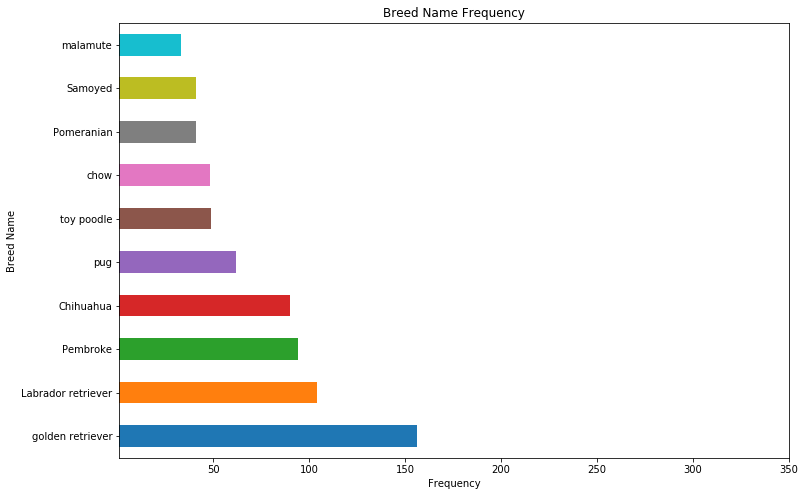

In [206]:
plt.figure(figsize=(12, 8))
breed_names = twit_arc_final.breed[twit_arc_final.breed != 'none'].value_counts().nlargest(10).plot(kind = 'barh');
breed_names.set_title('Breed Name Frequency');
breed_names.set_xlabel('Frequency');
breed_names.set_ylabel('Breed Name');
breed_names.set_xlim(1, 350);

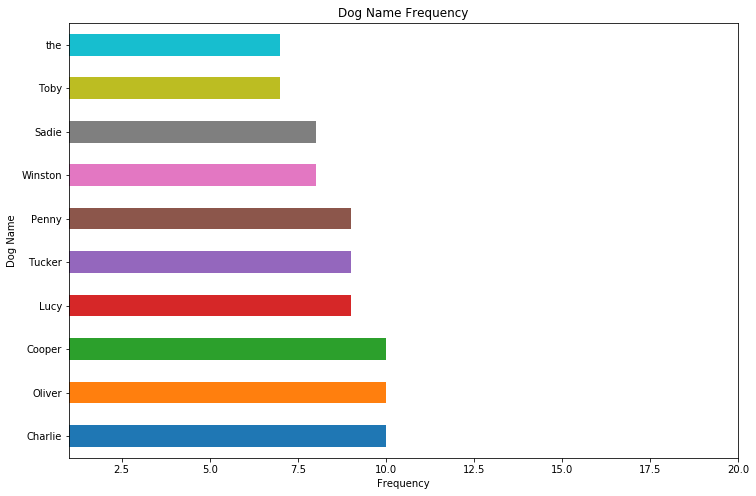

In [207]:
plt.figure(figsize=(12, 8))
names = twit_arc_final.name[twit_arc_final.name != 'None'][twit_arc_final.name != 'a'].value_counts().nlargest(10).plot(kind = 'barh');
names.set_title('Dog Name Frequency');
names.set_xlabel('Frequency');
names.set_ylabel('Dog Name');
names.set_xlim(1, 20);